# Visualizing BAMS embeddings for interpretability

In [1]:
import torch
import numpy as np

from bams.data import KeypointsDataset
from bams.models import BAMS
from bams import compute_representations
from custom_dataset_w_labels import load_data, load_annotations

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Load data + annotations

In [2]:
path = '...'
hoa_bins = 32
keypoints = load_data(path)
annotations, eval_utils = load_annotations(path)

dataset = KeypointsDataset(
        keypoints=keypoints,
        cache=False,
        hoa_bins=hoa_bins,
        annotations=annotations,
        eval_utils=eval_utils
    )
print("Number of sequences:", len(dataset))


100%|██████████| 28/28 [00:27<00:00,  1.02it/s]


Number of sequences: 290


### Load your trained model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BAMS(
        input_size=dataset.input_size,
        short_term=dict(num_channels=(64, 64, 64, 64), kernel_size=3),
        long_term=dict(num_channels=(64, 64, 64, 64, 64), kernel_size=3, dilation=4),
        predictor=dict(
            hidden_layers=(-1, 256, 512, 512, dataset.target_size * hoa_bins)
        ),
    ).to(device)
model.load_state_dict(torch.load('...'))
model.eval()

/nethome/mmendelson3/.local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


BAMS([
  short_term: TemporalConvNet (receptive field: 61, feature dim: 64),
  long_term: TemporalConvNet (receptive field: 1365, feature dim: 64),
  predictor: MLP (input size: 56, output size: 896)
])

### Compute representations for your entire dataset (may take a few minutes)

In [4]:
embeddings = compute_representations(model, dataset, device)

100%|██████████| 73/73 [04:24<00:00,  3.63s/it]


In [7]:
short_term = embeddings['short_term']
long_term = embeddings['long_term']
all_embeddings = torch.cat([short_term, long_term], dim=2)

In [9]:
# for sequence-level labels take the mean across frames
short_term_seq = torch.mean(short_term, dim=1, keepdim=False)
long_term_seq = torch.mean(long_term, dim=1, keepdim=False)
all_embeddings_seq = torch.cat([short_term_seq, long_term_seq], dim=1)

Now that you have your embeddings, both frame-level and sequence-level, whatever analyses you choose to perform is up to you! Below we will illustrate a simple analysis where visualize our embeddings projected into 2 dimensions using PCA. By coloring each session by our labels we can gain insights into the data and what the model may be encoding. Dataset-specific analyses will be needed to answer your specific scientific questions!

### Visualizing embeddings with PCA

In [10]:
# Fit PCA for each type of embeddings
pca = PCA(n_components=2)
pca.fit(short_term_seq)
short_term_pca = pca.transform(short_term_seq)
ev_short_term = pca.explained_variance_ratio_

pca = PCA(n_components=2)
pca.fit(long_term_seq)
long_term_pca = pca.transform(long_term_seq)
ev_long_term = pca.explained_variance_ratio_

pca = PCA(n_components=2)
pca.fit(all_embeddings_seq)
all_pca = pca.transform(all_embeddings_seq)
ev_all = pca.explained_variance_ratio_

[]

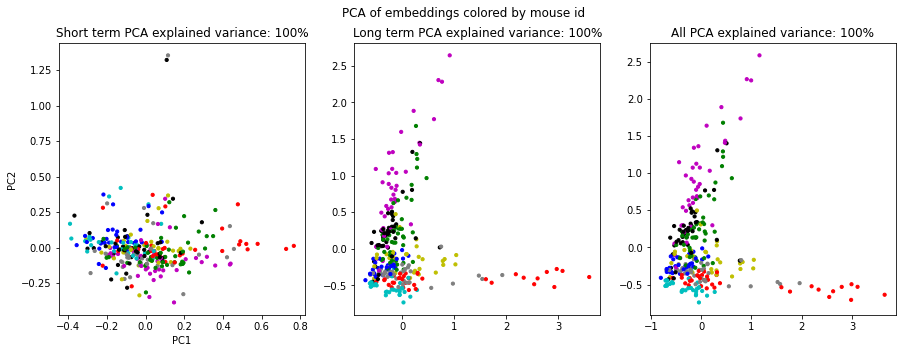

In [21]:
# Plot PCA colored by sequence-level labels (in this case, we are coloring by mouse identity)
color_list = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'tab:gray', 'pink', 'aqua', 'darkorange', 'purple']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
c = [color_list[i] for i in annotations['mouse']]
ax[0].scatter(short_term_pca[:, 0], short_term_pca[:, 1], c=c, s=10)
ax[0].set_title(f'Short term PCA explained variance: {round(sum(ev_short_term)*100)}%')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].scatter(long_term_pca[:, 0], long_term_pca[:, 1], c=c, s=10)
ax[1].set_title(f'Long term PCA explained variance: {round(sum(ev_long_term)*100)}%')  
ax[2].scatter(all_pca[:, 0], all_pca[:, 1], c=c, s=10)
ax[2].set_title(f'All PCA explained variance: {round(sum(ev_all)*100)}%')
plt.suptitle('PCA of embeddings colored by mouse id')
plt.plot()